In [1]:
import torch
from torch.utils.data import DataLoader
from levee_hunter.augmentations import (
    no_deformations_transform,
    normalize_only,
    train_transform,
)
from levee_hunter.segmentation_dataset import SegmentationDataset
from levee_hunter.utils import count_parameters
from levee_hunter.plots import infer_and_visualize
from levee_hunter.train_test_split_dataset import train_test_split_dataset
from levee_hunter.modeling.train import train_model
import numpy as np
import segmentation_models_pytorch as smp

import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

/Users/pawel/miniforge3/envs/Fathom/lib/python3.11/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.4 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/Users/pawel/1PhD_UCL/Fathom/GitHub_Stuff/levee_hunter/augmentations.py:12: UserWarning: Argument 'alpha_affine' is not valid and will be ignored.
  A.ElasticTransform(
/Users/pawel/miniforge3/envs/Fathom/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/pawel/miniforge3/envs/Fathom/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /Users/pawel/miniforge3/envs/Fathom/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/Users/pawel/miniforge3/envs/Fath

In [2]:
# Load the datasets
good_dataset = torch.load(
    "../data/intermediate/w3-4-based-datasets/good_dataset_13_512.pth"
)
better_dataset = torch.load(
    "../data/intermediate/w3-4-based-datasets/better_dataset_13_512.pth"
)
bad_dataset = torch.load(
    "../data/intermediate/w3-4-based-datasets/bad_dataset_13_512.pth"
)

print(len(good_dataset))
print(len(better_dataset))
print(len(bad_dataset))

/var/folders/tk/2_f29kq533g52jyhs9y4xt000000gn/T/ipykernel_45715/3151040643.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  good_dataset = torch.load(
/var/folders/tk/2_

429
247
190


In [3]:
# Set transforms, for training use augmentations, for testing just normalize
good_dataset.transform = no_deformations_transform
better_dataset.transform = no_deformations_transform
bad_dataset.transform = normalize_only


device = "cuda" if torch.cuda.is_available() else "cpu"

good_dataset.weights.shape

torch.Size([429])

In [4]:
good_dataset.weights_return

False

In [5]:
good_dataset.transform = train_transform

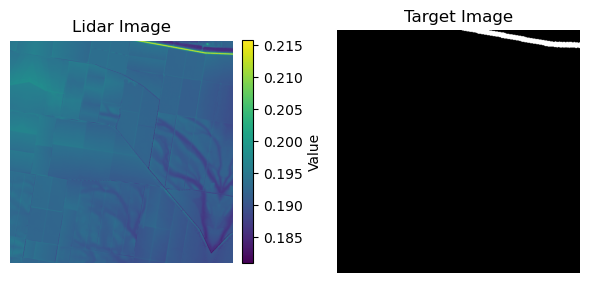

In [6]:
good_dataset.plot(139, transform=True)

In [7]:
training_dataset, val_dataset = train_test_split_dataset(good_dataset, test_size=0.2)

len(training_dataset), len(val_dataset)

(343, 86)

In [8]:
training_dataset.weights.shape

torch.Size([343])

In [9]:
training_dataset.weights_return

False

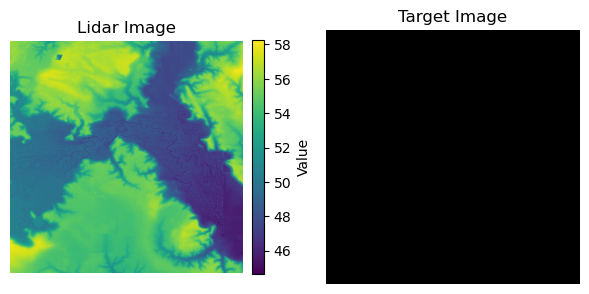

In [10]:
training_dataset.plot(19)

In [11]:
batch_size = 32

train_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

train_loader.dataset.images[0].shape, len(train_loader.dataset.images)

((1, 512, 512), 343)

In [12]:
model = smp.Unet(
    encoder_name="resnet34", encoder_weights="imagenet", in_channels=1, classes=1
).to(device)

# Define weighted loss function
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [13]:
training_dataset.weights_return = True

In [14]:
model, train_loss, val_loss = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=nn.BCEWithLogitsLoss(reduction="none"),
    epochs=25,
    save_model=True,
    save_model_path="../models/w4-based-models/Unet-13_512.pth",
)

beginning training on device: cpu
Epoch: 1/25 Train Loss: 0.605930 Val Loss: 12.656421
Model successfully saved to: ../models/w4-based-models/Unet-13_512.pth
Epoch: 2/25 Train Loss: 0.360284 Val Loss: 0.335879
Model successfully saved to: ../models/w4-based-models/Unet-13_512.pth
Epoch: 3/25 Train Loss: 0.232897 Val Loss: 0.212661
Model successfully saved to: ../models/w4-based-models/Unet-13_512.pth
Epoch: 4/25 Train Loss: 0.159822 Val Loss: 0.125132
Model successfully saved to: ../models/w4-based-models/Unet-13_512.pth
Epoch: 5/25 Train Loss: 0.121929 Val Loss: 0.108279
Model successfully saved to: ../models/w4-based-models/Unet-13_512.pth
Epoch: 6/25 Train Loss: 0.100399 Val Loss: 0.115384
Epoch: 7/25 Train Loss: 0.082477 Val Loss: 0.116474
Epoch: 8/25 Train Loss: 0.069435 Val Loss: 0.115993
Epoch: 9/25 Train Loss: 0.062561 Val Loss: 0.093805
Model successfully saved to: ../models/w4-based-models/Unet-13_512.pth
Epoch: 10/25 Train Loss: 0.056442 Val Loss: 0.059297
Model successfully

In [22]:
model.load_state_dict(torch.load("../models/w4-based-models/Unet-13_512.pth"))

/var/folders/tk/2_f29kq533g52jyhs9y4xt000000gn/T/ipykernel_45715/577322209.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("../models/w4

<All keys matched successfully>

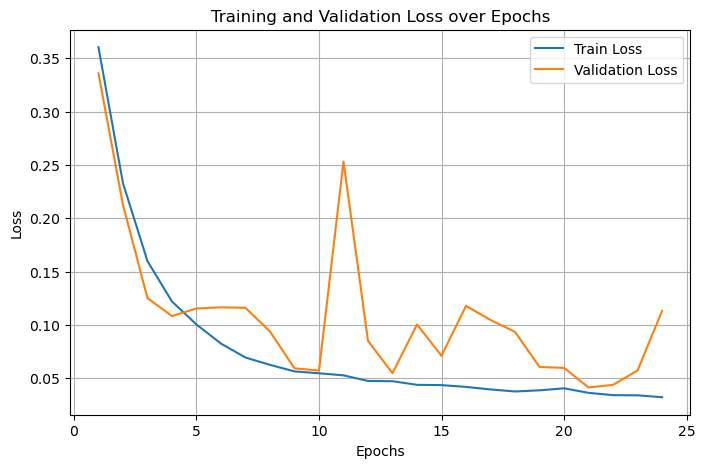

In [20]:
plot_training_validation_loss(train_loss[1:], val_loss[1:])

0


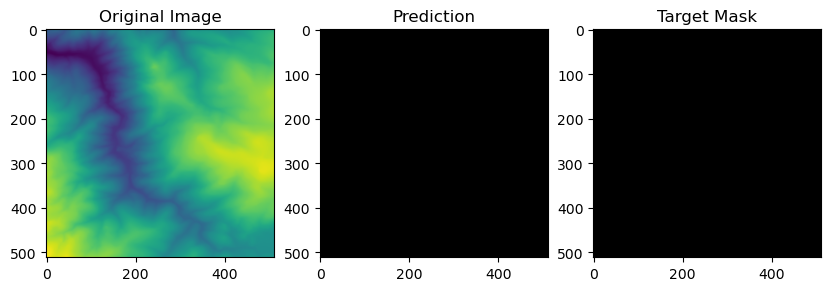

1


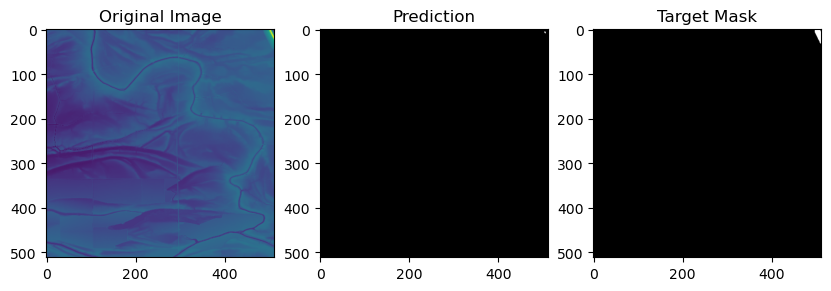

2


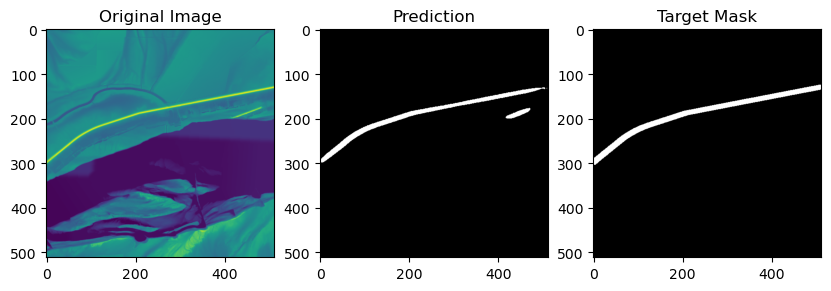

3


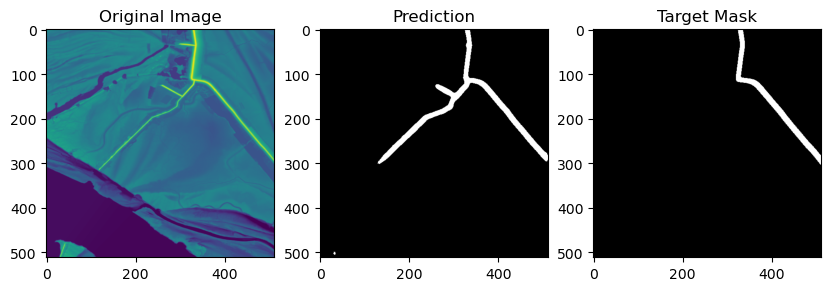

4


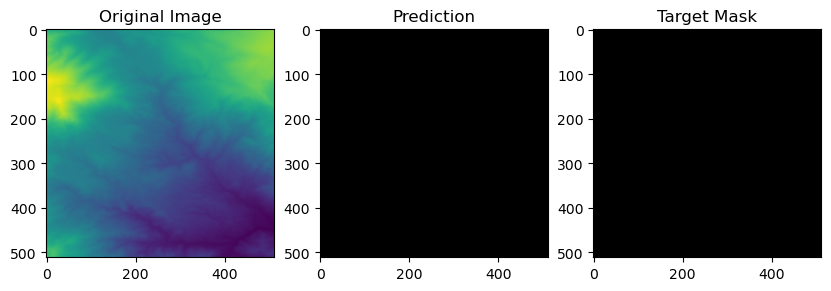

5


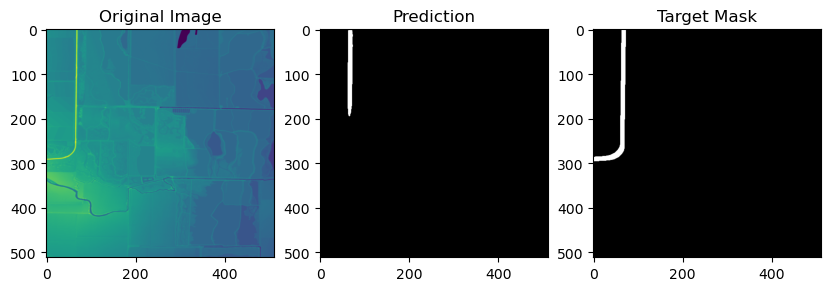

6


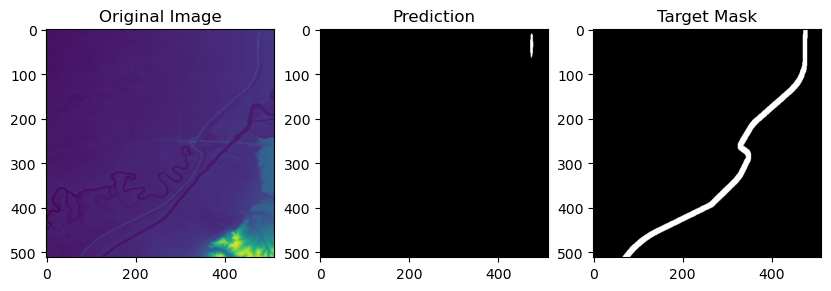

7


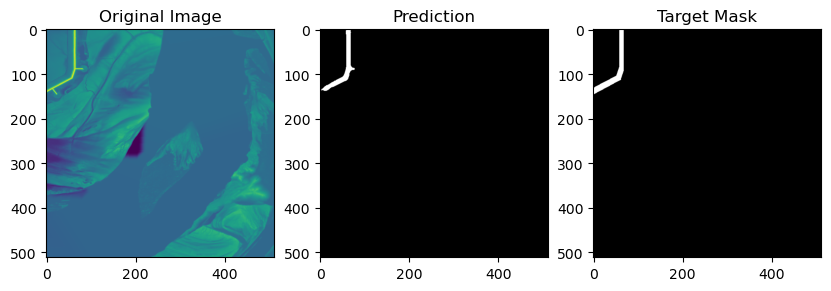

8


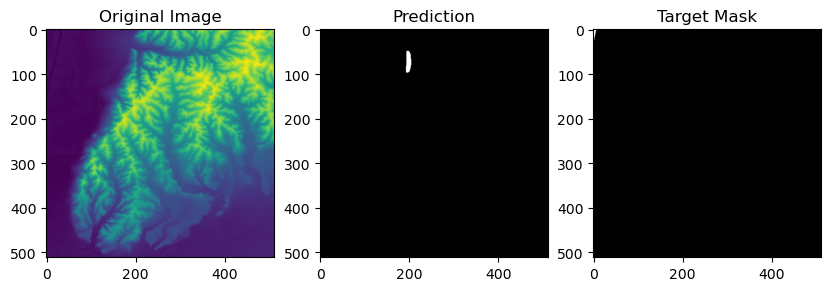

9


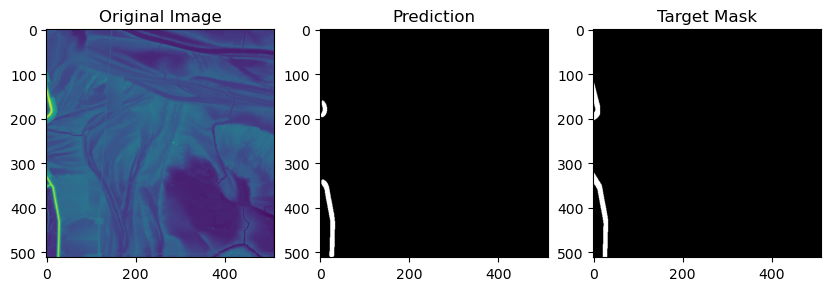

10


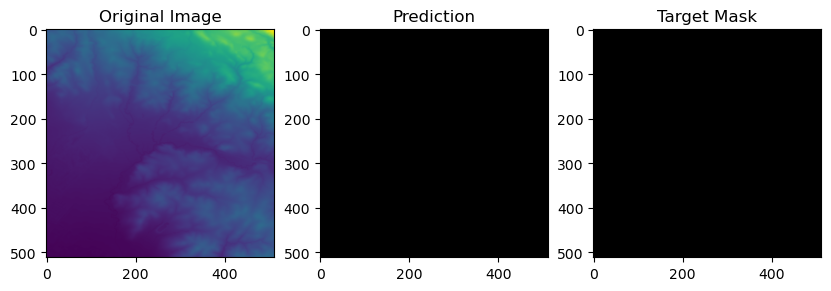

11


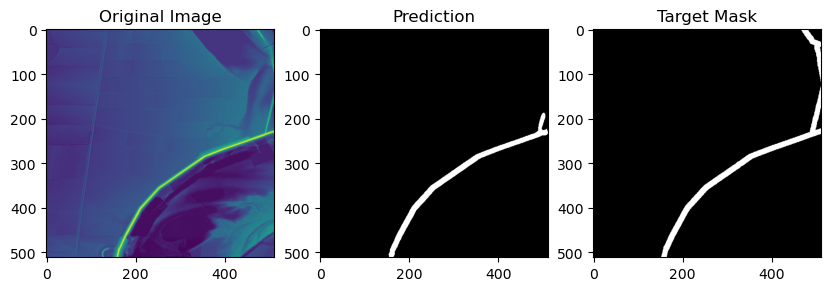

12


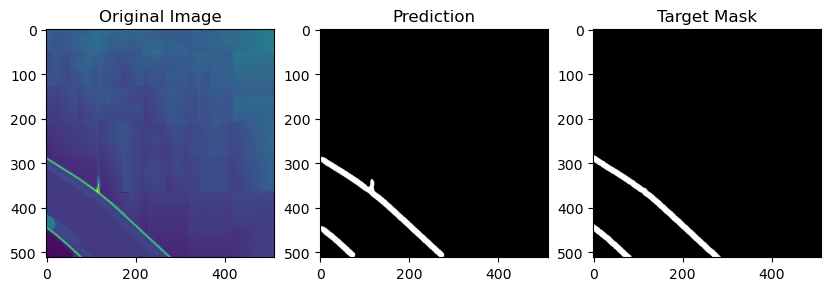

13


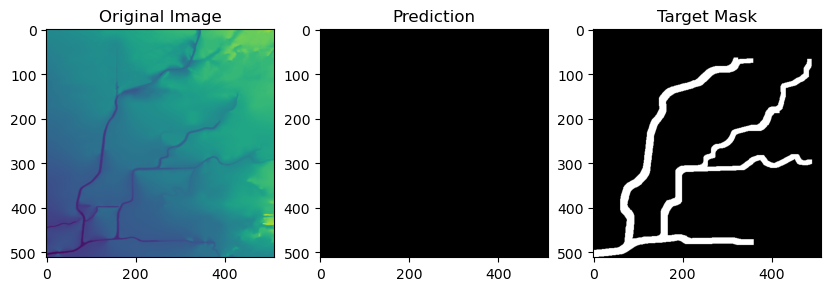

14


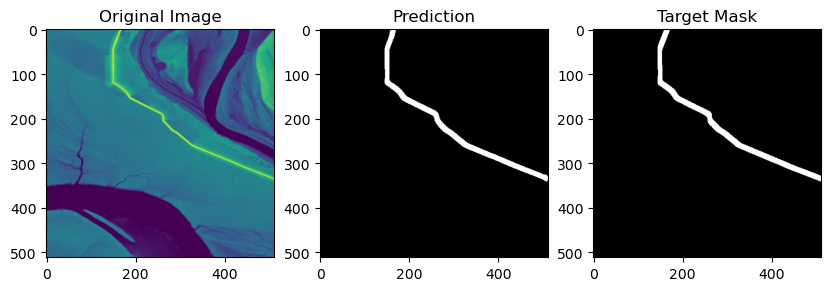

15


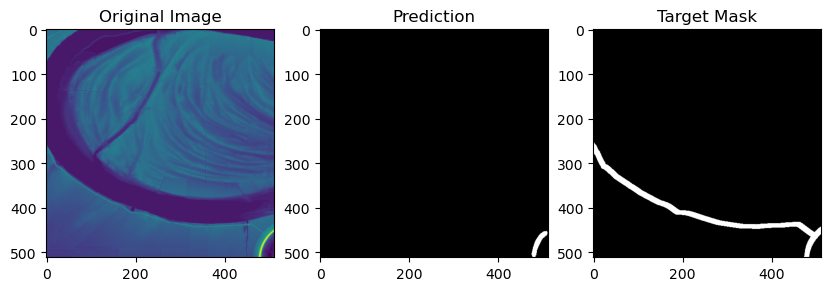

16


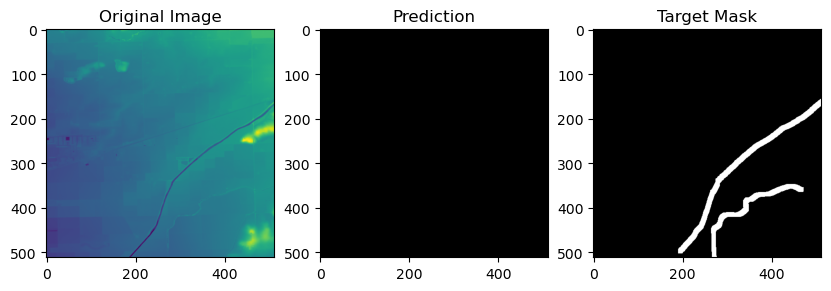

17


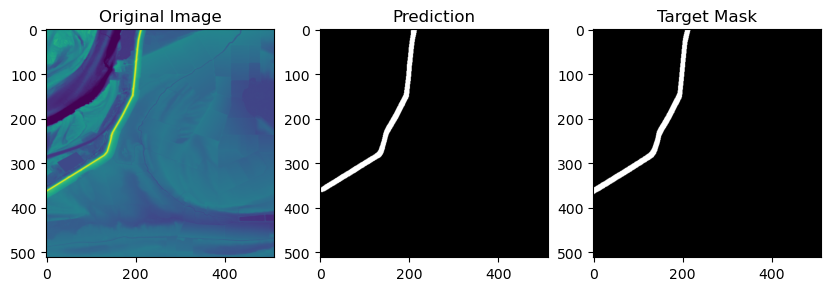

18


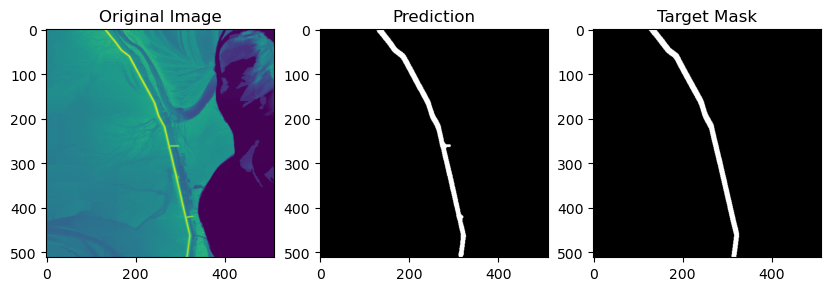

19


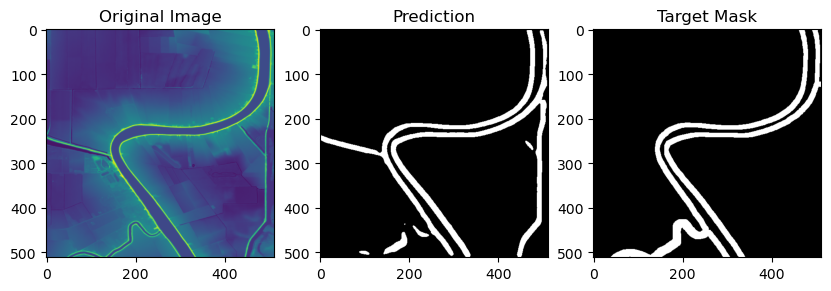

20


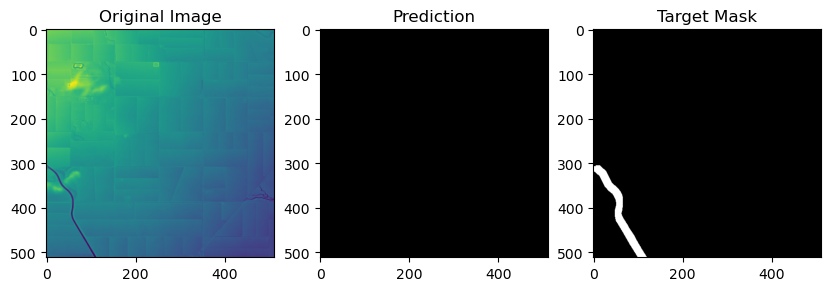

21


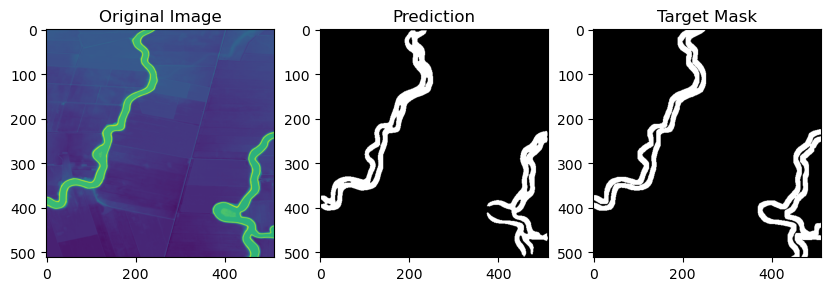

22


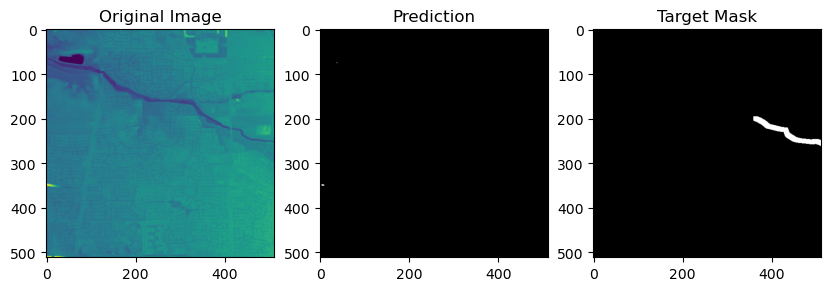

23


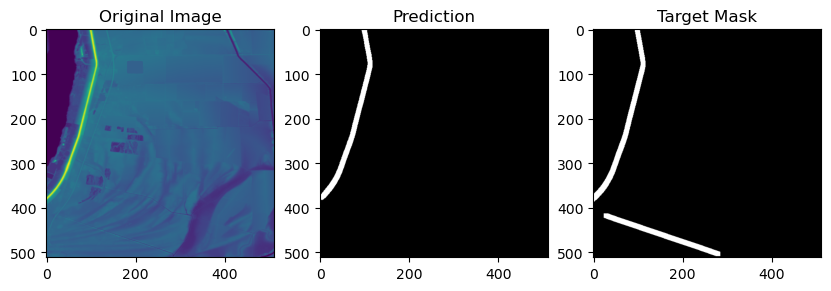

24


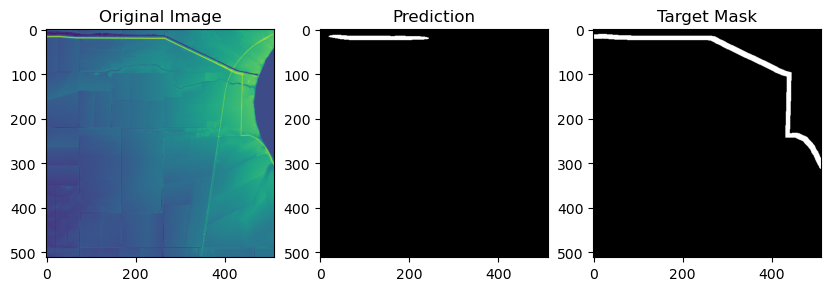

25


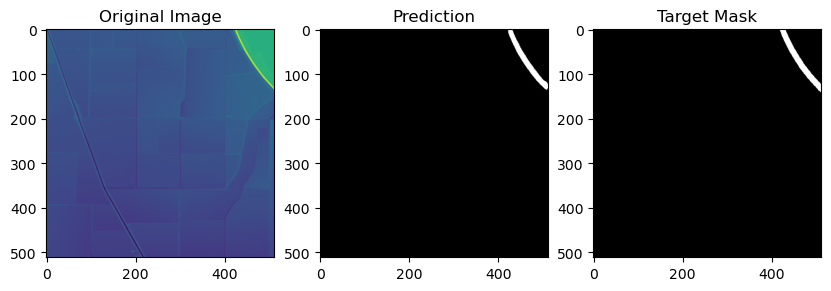

26


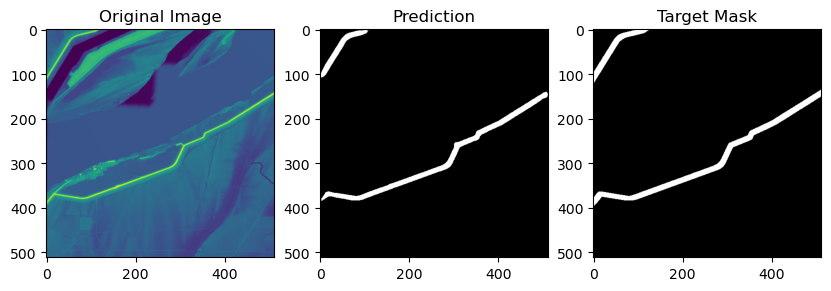

27


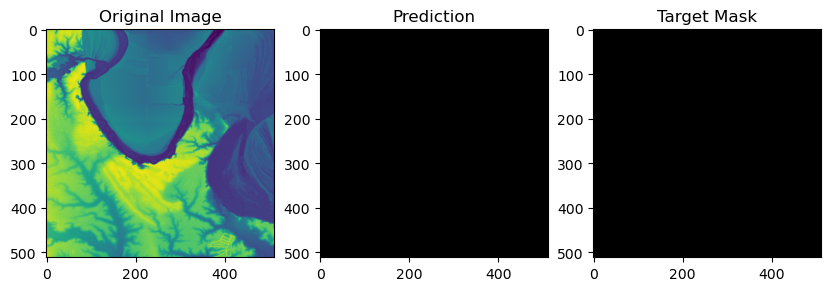

28


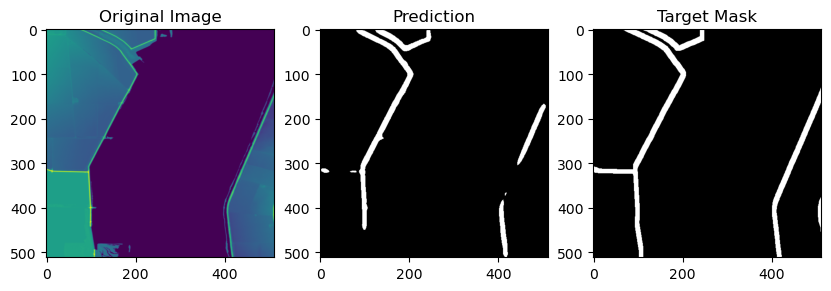

29


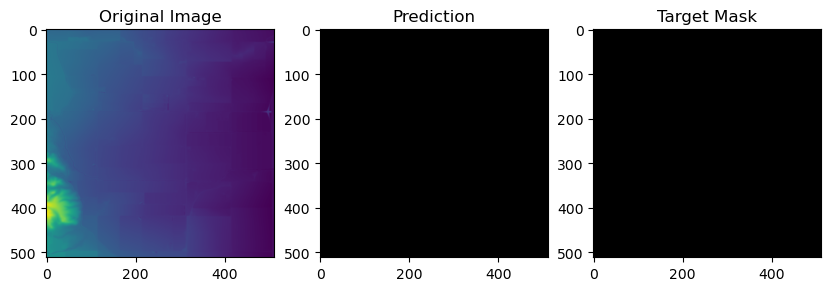

30


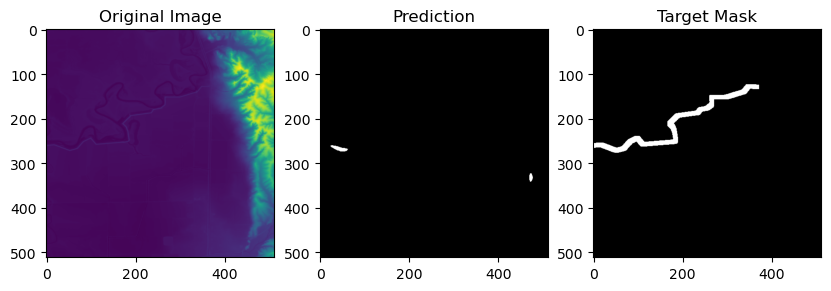

31


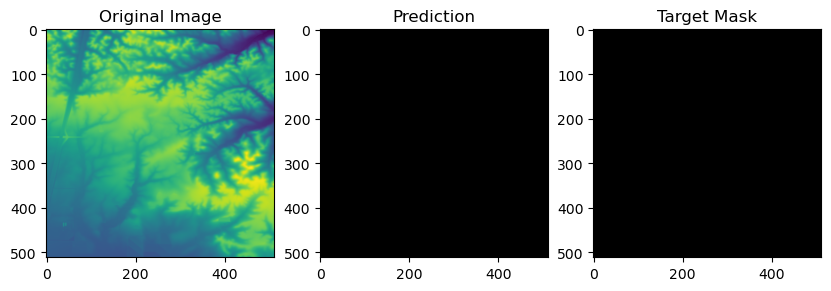

32


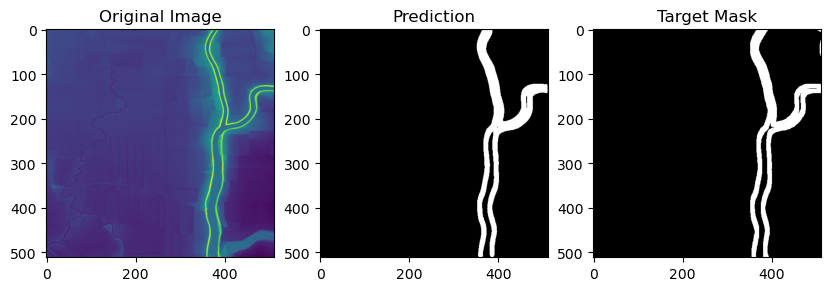

33


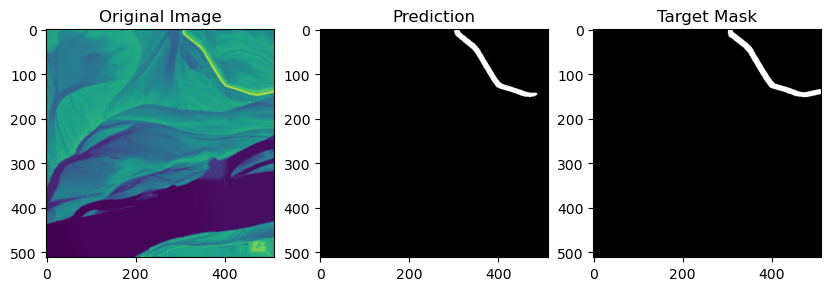

34


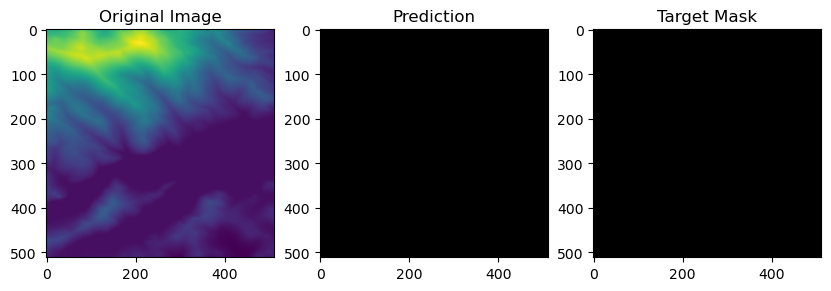

35


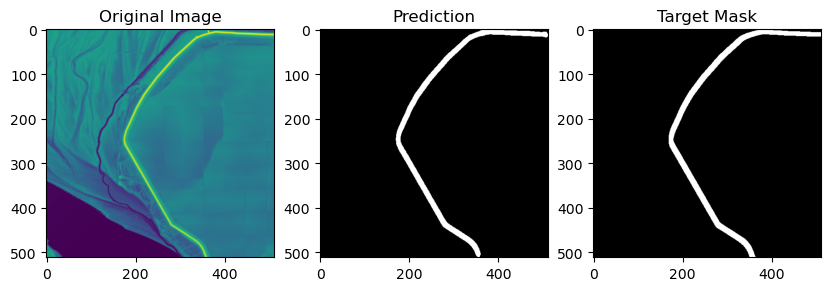

36


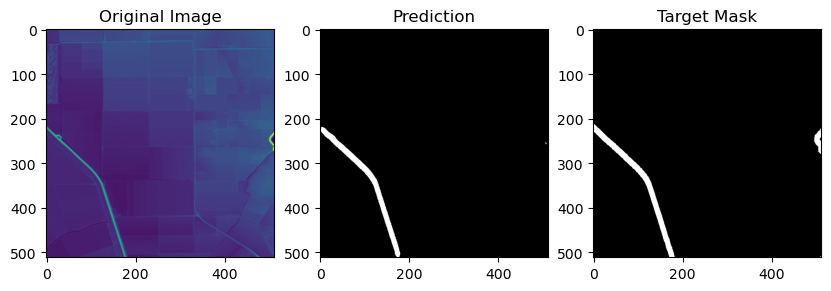

37


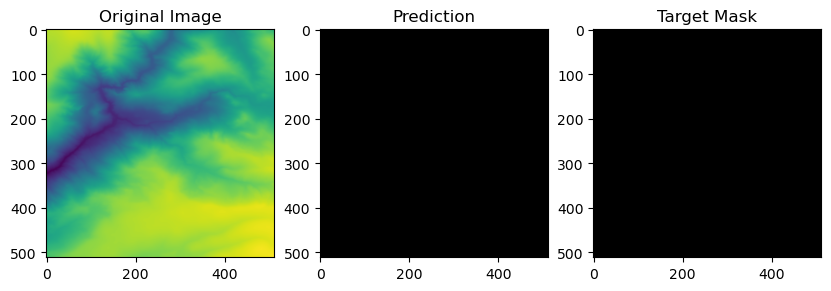

38


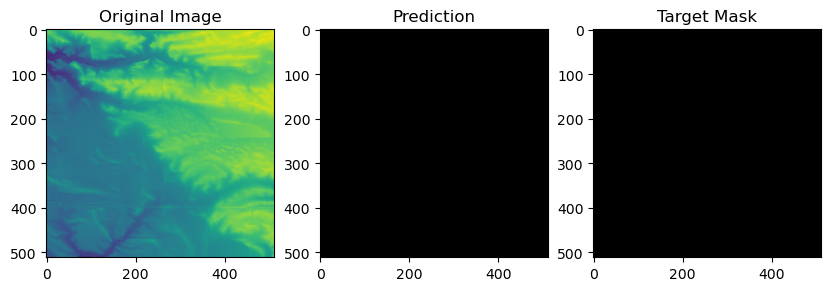

39


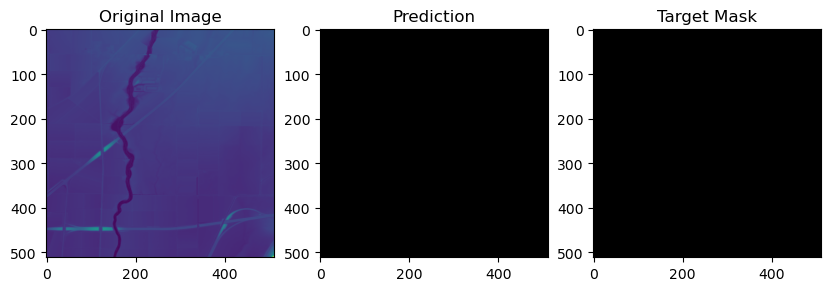

40


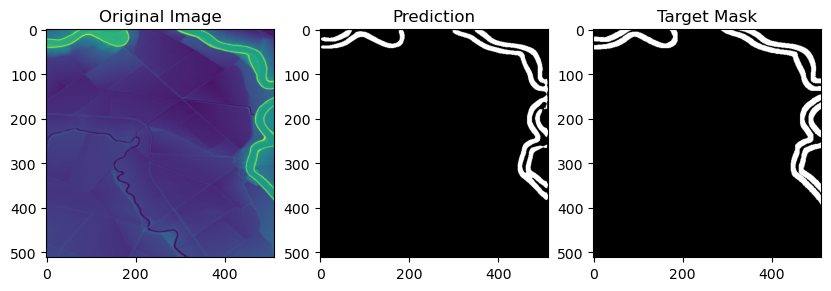

41


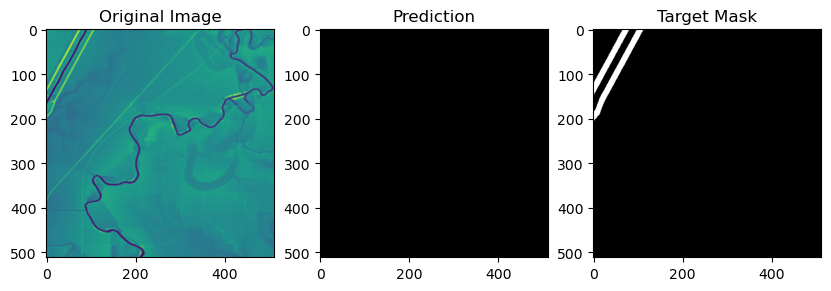

42


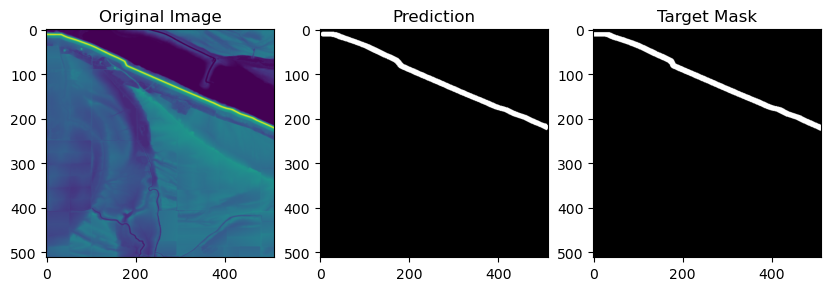

43


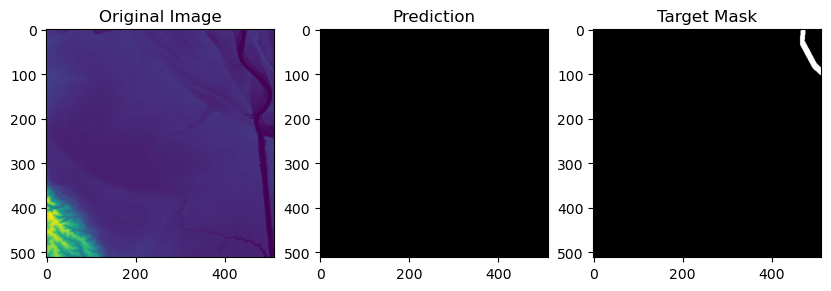

44


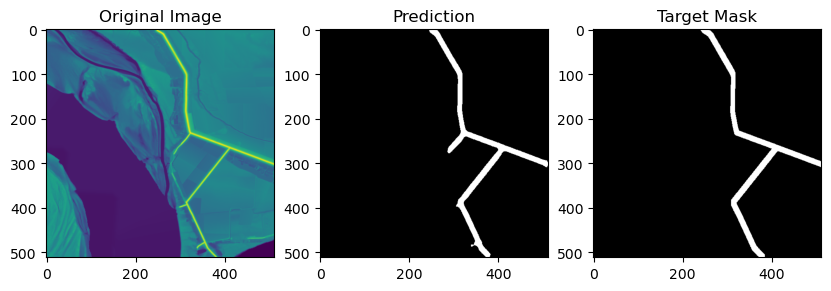

45


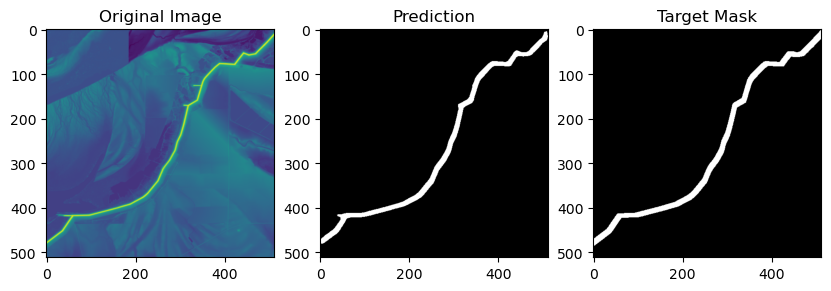

46


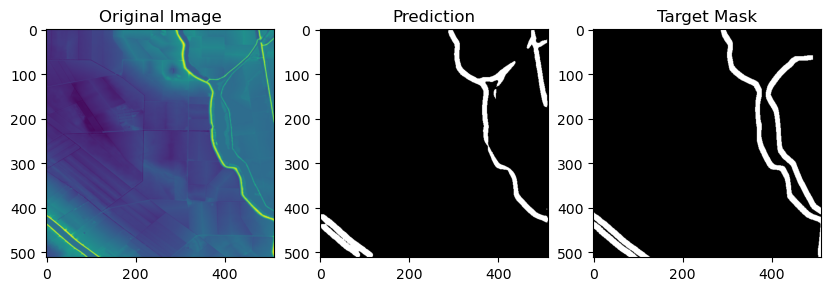

47


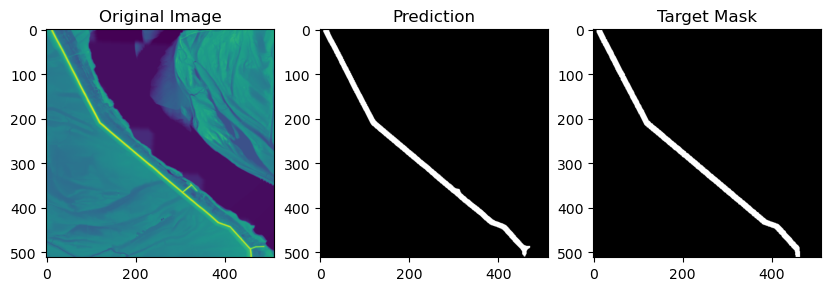

48


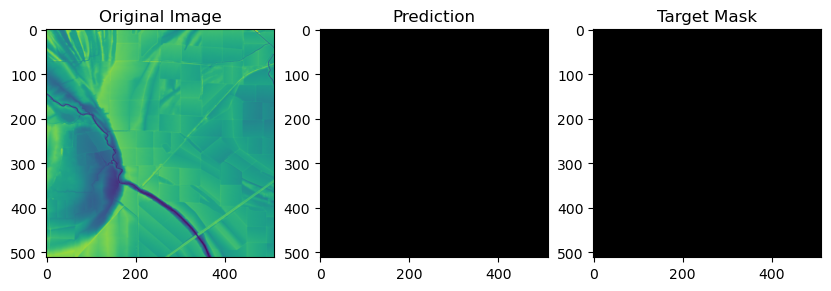

49


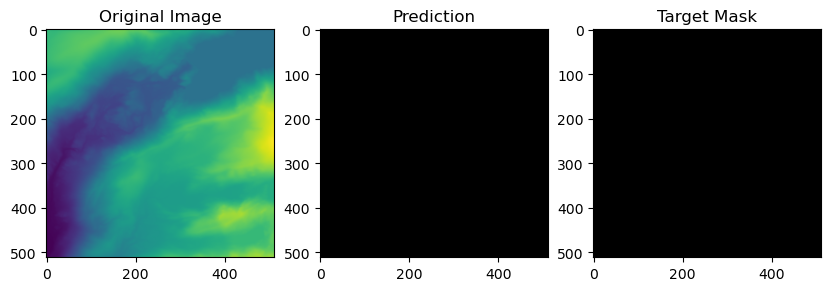

50


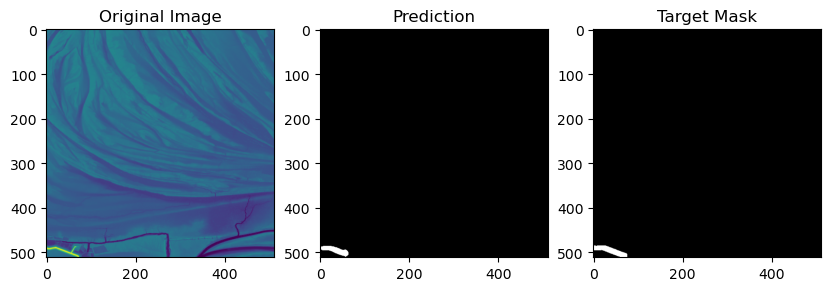

51


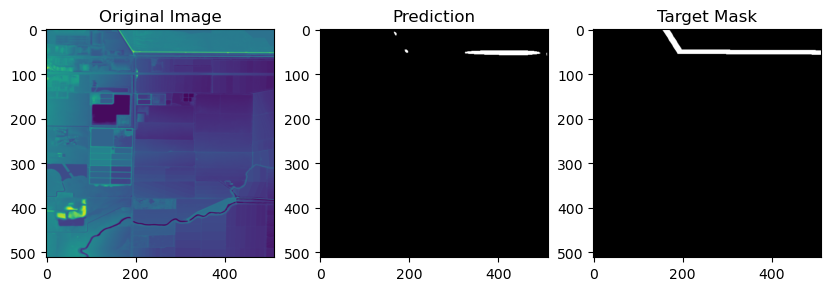

52


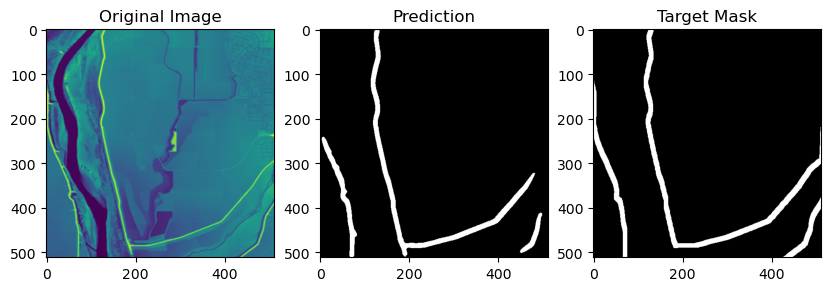

53


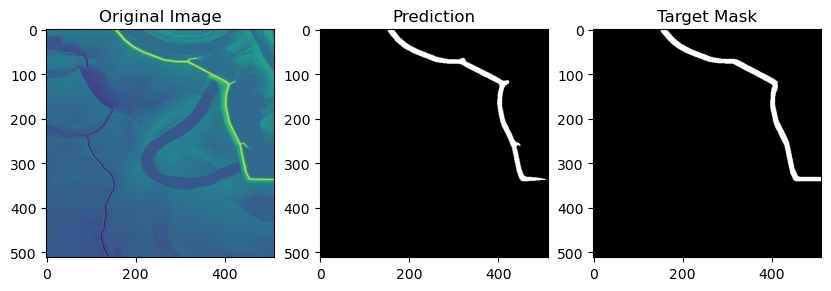

54


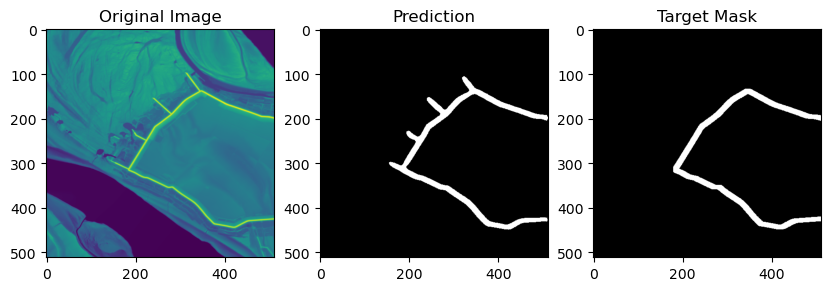

55


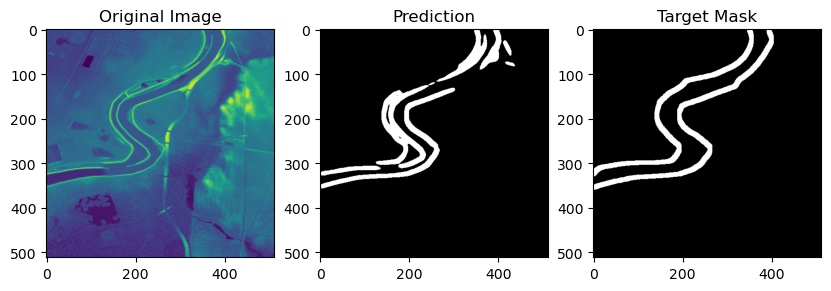

56


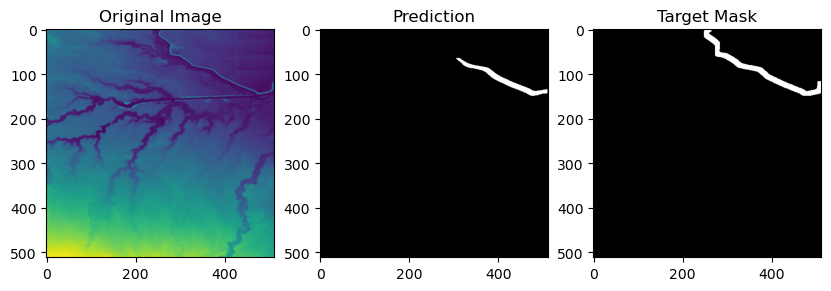

57


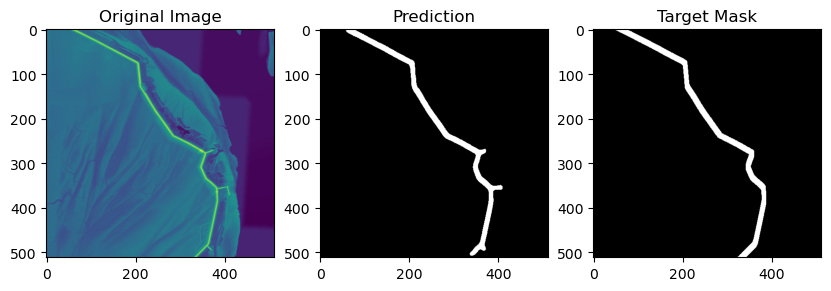

58


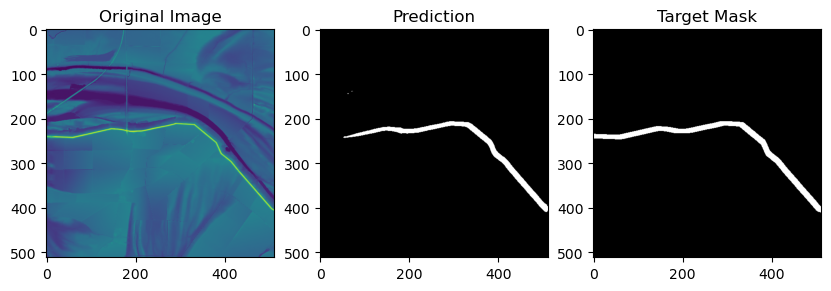

59


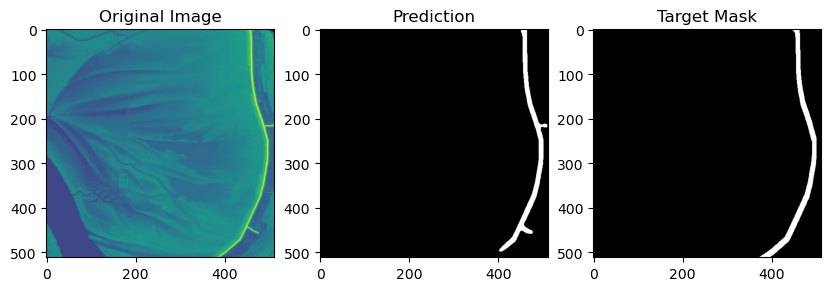

60


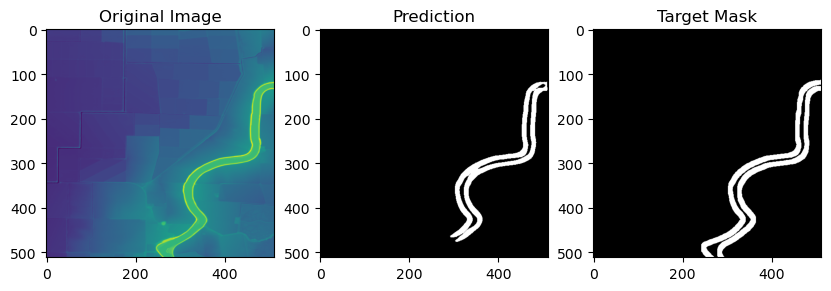

61


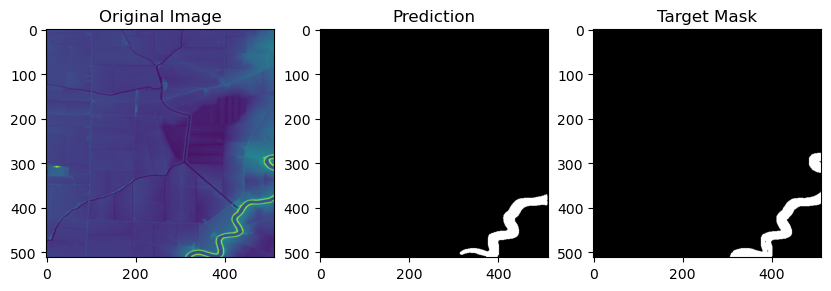

62


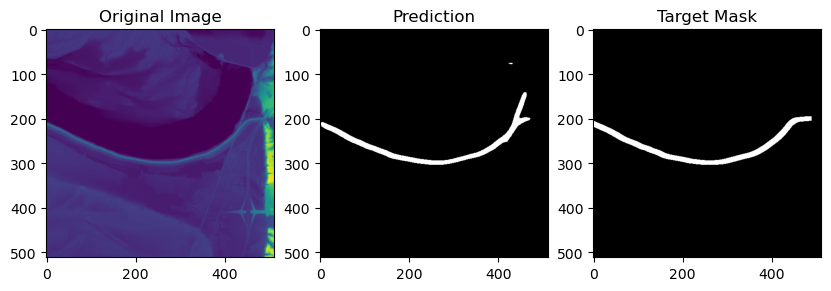

63


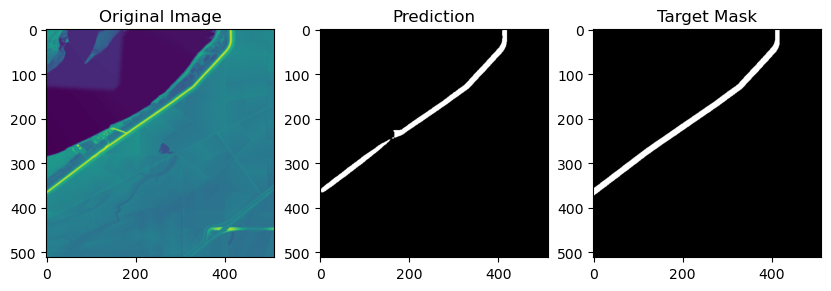

64


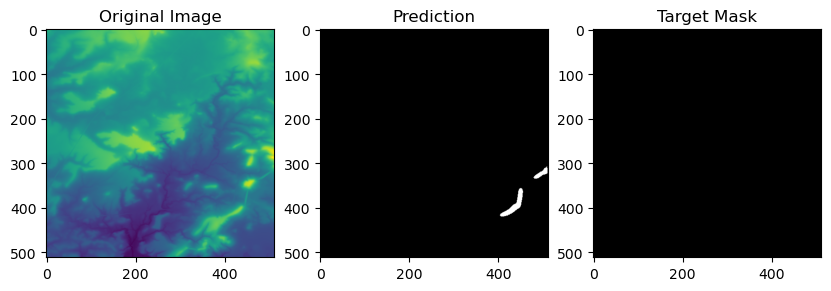

65


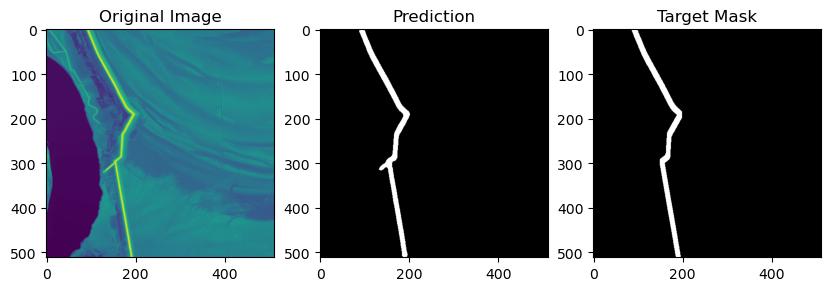

66


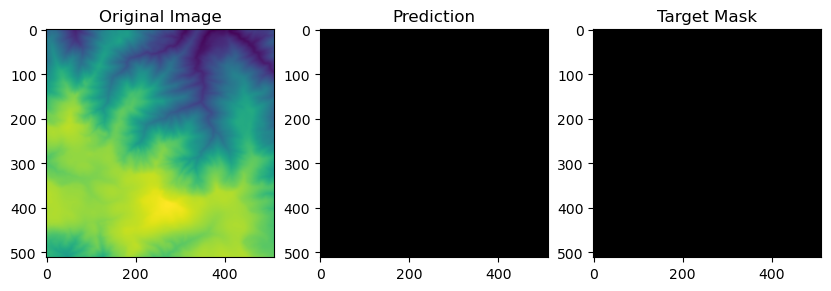

67


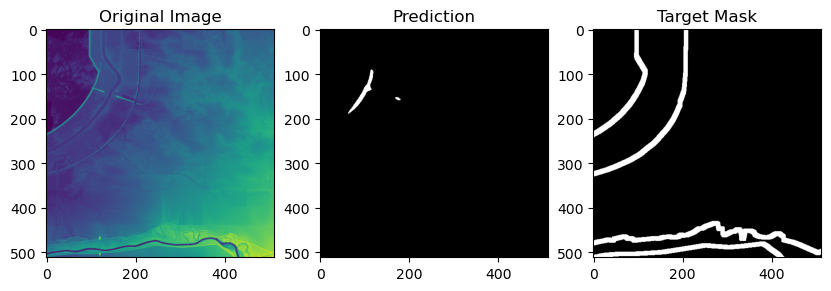

68


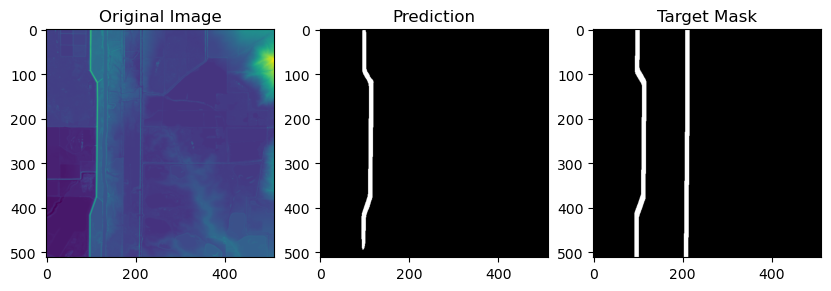

69


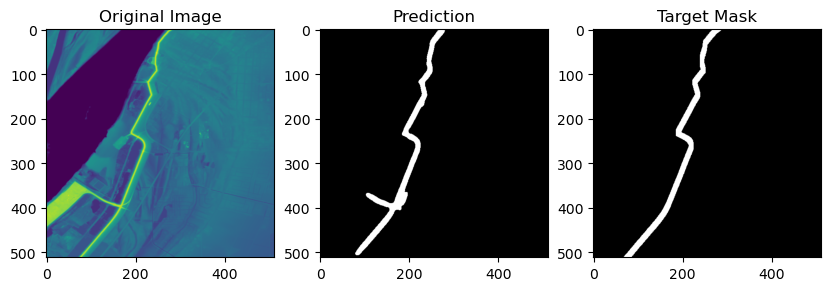

70


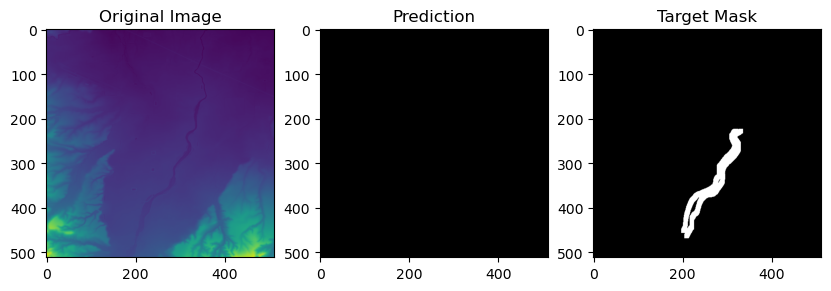

71


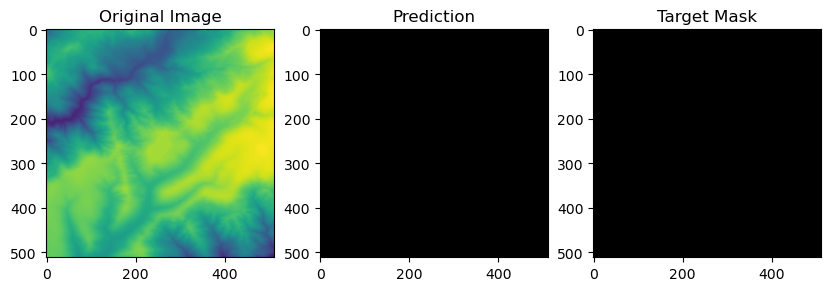

72


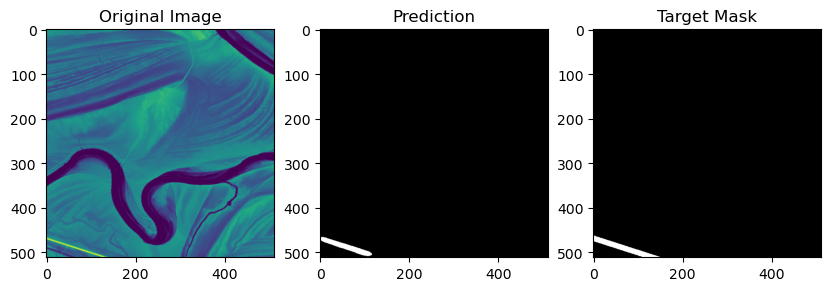

73


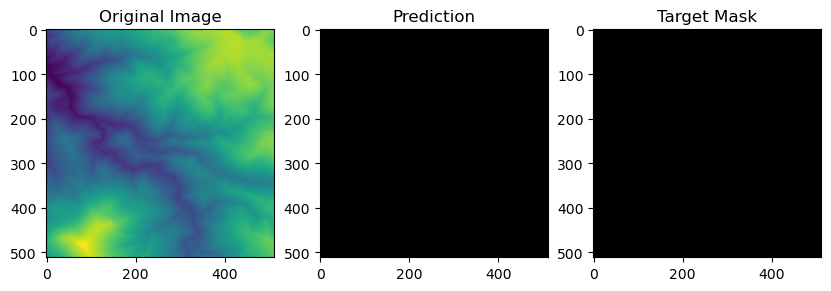

74


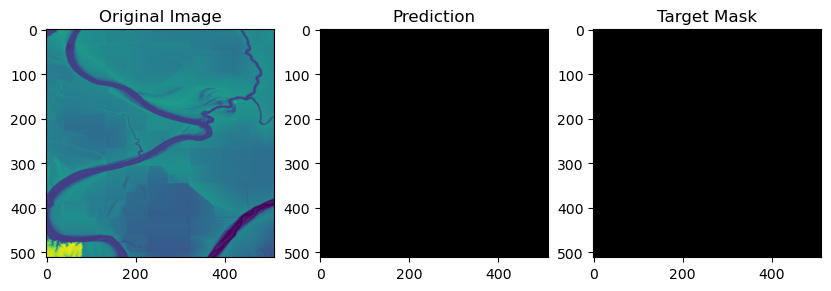

75


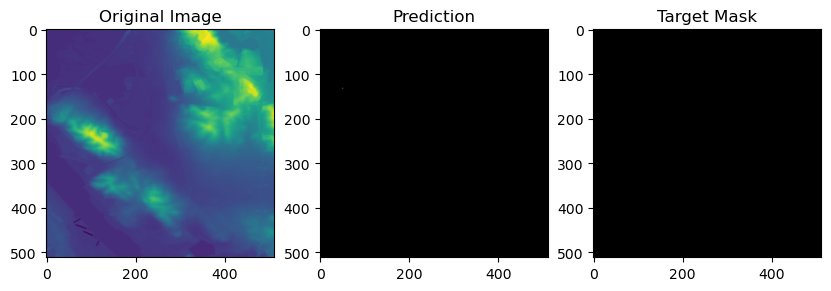

76


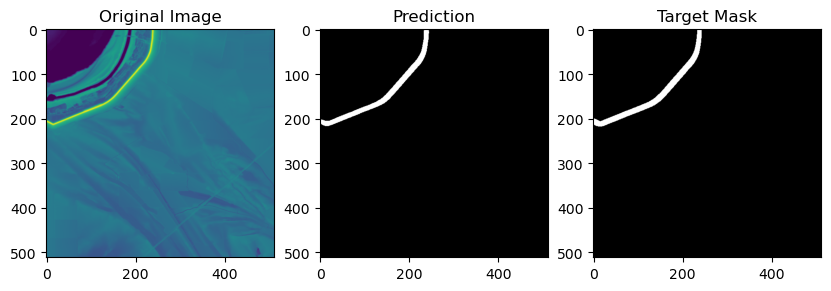

77


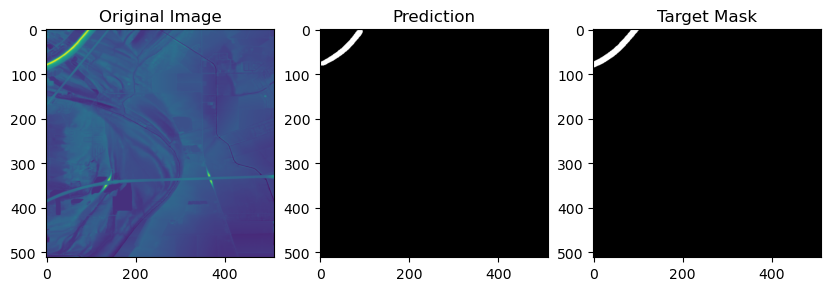

78


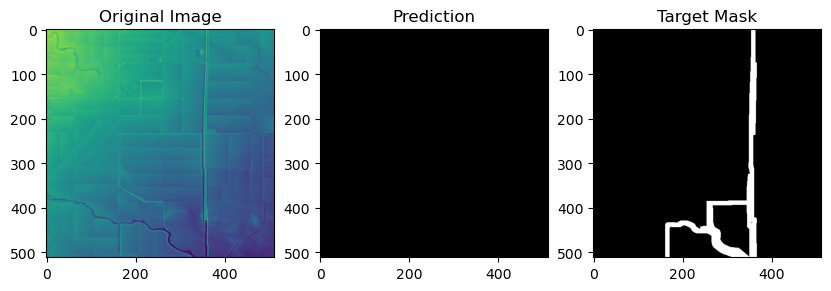

79


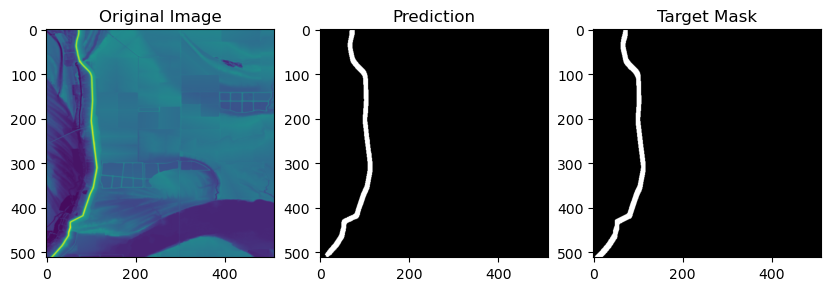

In [25]:
for ix in range(80):
    sample_image, sample_mask = val_dataset[ix]
    # sample_image = sample_image.unsqueeze(0)
    print(ix)
    output = infer_and_visualize(model, sample_image, sample_mask, apply_sigmoid=True)

In [24]:
torch.save(
    training_dataset, "../data/processed/w3-4-based-datasets/train_dataset_13_512.pth"
)
torch.save(val_dataset, "../data/processed/w3-4-based-datasets/val_dataset_13_512.pth")